In [ ]:
from IPython.core.display import HTML
with open('./style.css') as f:
    css = f.read()
HTML(css)

In [ ]:
import chess                                       # Simulate the chess game
import chess.gaviota                               # Load Gaviota Tablebase
from IPython.display import display, clear_output  # Better visualization and display of the chess board
import random                                      # Random moves and random creation of endgame positions
from typing import Union, List, Set  
import re              # Types to enable direct method signatures

<div style="text-align: justify">
(a) Zunächst wird die Menge aller möglichen zulässigen Stellungen berechnet.  Diese Menge
       bezeichnen wir mit S.  (Eine Stellung ist unzulässig, wenn der König des Spielers,
       der nicht am Zug ist, im Schach steht.)
</div>

In [ ]:
#TODO: Add bishop validation

def generate_positions(pieces: List[chess.Piece]) -> Set[str]:
    board = chess.Board()
    board.clear()

    def piece_count(epd_str):
        start_epd = epd_str.split(" ")[0]
        return len(re.findall("[a-zA-Z]", start_epd))
        
    s = set()
    
    for turn in range(2):
        board.turn = chess.WHITE if turn == 0 else chess.BLACK
        for x in range(64):
            for y in range(64):
                for z in range(64):
                    board.set_piece_at(x, pieces[0])
                    board.set_piece_at(y, pieces[1])
                    board.set_piece_at(z, pieces[2])
                    
                    if board.is_valid() and piece_count(board.epd()) == len(pieces):
                        s.add(board.epd())

                    board.clear_board()

    return s

In [ ]:
s = generate_positions([chess.Piece(chess.KING, chess.WHITE), chess.Piece(chess.KING, chess.BLACK), chess.Piece(chess.ROOK, chess.BLACK)])

<div style="text-align: justify">
(b) Anschließend werden alle Stellungen aus der Menge S gesucht, in denen der Spieler, der am Zug ist,
       schachmatt ist.  Diese Stellungen werden zu einer Menge S_0 zusammengefasst.  Außerdem werden diese
       Stellungen aus der Menge S entfernt.
</div>
<br>
S: Alle validen Stellungen, Weiß ist am Zug
<br>
S0: weiß ist am Zug und matt, hat keinen validen Zug mehr
<br>
S1: schwarz ist am Zug und kann mit einem Move eine Stellung aus S0 erreichen
<br>
S2: weiß ist am Zug und jeder Move landet in einer Stellung aus S1

In [ ]:
def generate_mate_positions(s: Set[str]) -> Set[str]:
    s0 = set()
    for epd in s:
        if chess.Board(epd).is_checkmate():
            s0.add(epd)
    s = set(s) - s0
    return s, s0

In [ ]:
s, s0 = generate_mate_positions(s)

In [ ]:
len(s0)

216

(c) Nun werden alle Stellungen aus S berechnet, in denen der Spieler mit seinem nächsten Zug den Gegner Matt setzen kann, d.h. eine Stellung aus der Menge S_0 erreichen kann. Diese Stellungen werden zu einer Menge S_1 zusammen gefasst und aus der Menge S entfernt. S_1 enthält also alle die Stellungen, in denen der Gegener unmittelbar matt gesetzt werden kann.

In [ ]:
s0

{'1K1r4/8/1k6/8/8/8/8/8 w - -',
 '1K2r3/8/1k6/8/8/8/8/8 w - -',
 '1K3r2/8/1k6/8/8/8/8/8 w - -',
 '1K4r1/8/1k6/8/8/8/8/8 w - -',
 '1K5r/8/1k6/8/8/8/8/8 w - -',
 '1r1K4/8/3k4/8/8/8/8/8 w - -',
 '1r2K3/8/4k3/8/8/8/8/8 w - -',
 '1r3K2/8/5k2/8/8/8/8/8 w - -',
 '1r4K1/8/6k1/8/8/8/8/8 w - -',
 '1r5K/8/6k1/8/8/8/8/8 w - -',
 '1r5K/8/7k/8/8/8/8/8 w - -',
 '2K1r3/8/2k5/8/8/8/8/8 w - -',
 '2K2r2/8/2k5/8/8/8/8/8 w - -',
 '2K3r1/8/2k5/8/8/8/8/8 w - -',
 '2K4r/8/2k5/8/8/8/8/8 w - -',
 '2r1K3/8/4k3/8/8/8/8/8 w - -',
 '2r2K2/8/5k2/8/8/8/8/8 w - -',
 '2r3K1/8/6k1/8/8/8/8/8 w - -',
 '2r4K/8/6k1/8/8/8/8/8 w - -',
 '2r4K/8/7k/8/8/8/8/8 w - -',
 '3K1r2/8/3k4/8/8/8/8/8 w - -',
 '3K2r1/8/3k4/8/8/8/8/8 w - -',
 '3K3r/8/3k4/8/8/8/8/8 w - -',
 '3r1K2/8/5k2/8/8/8/8/8 w - -',
 '3r2K1/8/6k1/8/8/8/8/8 w - -',
 '3r3K/8/6k1/8/8/8/8/8 w - -',
 '3r3K/8/7k/8/8/8/8/8 w - -',
 '4K1r1/8/4k3/8/8/8/8/8 w - -',
 '4K2r/8/4k3/8/8/8/8/8 w - -',
 '4r1K1/8/6k1/8/8/8/8/8 w - -',
 '4r2K/8/6k1/8/8/8/8/8 w - -',
 '4r2K/8/7k/8/8/8/8/8 

In [ ]:
def generate_dtm_positions(s: Set[str], sn: Set[str]) -> Set[str]:
    sm = set()
    old_perc = 0
    for i, epd in enumerate(s):

        if i%1000 == 0: 
            clear_output()
            print(f"{i}/{len(s)} -> {int((i/len(s))*100)}%")
        
        board = chess.Board(epd)

        for move in board.legal_moves:
            board.push(move)
            if board.epd() in sn:
                board.pop()
                sm.add(board.epd())
                break
            board.pop()

    s = set(s) - sm
    return s, sm

In [ ]:
s, s1 = generate_dtm_positions(s, s0)

398000/398896 -> 99%


In [ ]:
len(s1)

1512

In [ ]:
s1

{'6r1/8/K1k5/8/8/8/8/8 b - -',
 '4r3/8/8/8/8/2k5/8/2K5 b - -',
 '8/5k1K/8/8/r7/8/8/8 b - -',
 '3K4/8/3k4/6r1/8/8/8/8 b - -',
 '8/8/8/8/6r1/8/5k1K/8 b - -',
 '5k1K/8/8/8/8/r7/8/8 b - -',
 '3K4/8/3k2r1/8/8/8/8/8 b - -',
 '7K/5k2/8/1r6/8/8/8/8 b - -',
 '8/1r6/8/8/8/3k4/8/3K4 b - -',
 '8/8/8/8/8/1k2r3/8/1K6 b - -',
 '2K5/r7/2k5/8/8/8/8/8 b - -',
 'K7/8/k7/8/8/8/6r1/8 b - -',
 '6r1/8/8/8/8/K1k5/8/8 b - -',
 'K7/3r4/k7/8/8/8/8/8 b - -',
 '8/8/8/8/8/2r2k2/8/5K2 b - -',
 '8/8/8/2r5/8/8/8/K1k5 b - -',
 '8/8/8/8/8/5k2/7r/5K2 b - -',
 '8/8/K1k5/8/2r5/8/8/8 b - -',
 '8/8/8/8/8/3k2r1/8/3K4 b - -',
 '6K1/3r4/6k1/8/8/8/8/8 b - -',
 '8/8/4r3/8/8/k7/8/K7 b - -',
 '8/5k1K/8/8/8/8/4r3/8 b - -',
 '5k1K/8/1r6/8/8/8/8/8 b - -',
 '3K4/8/r2k4/8/8/8/8/8 b - -',
 '8/K1k5/8/8/8/3r4/8/8 b - -',
 '7K/5k2/8/8/3r4/8/8/8 b - -',
 '6K1/8/6k1/8/r7/8/8/8 b - -',
 '5K2/8/5k2/2r5/8/8/8/8 b - -',
 '7K/8/6k1/8/8/8/8/1r6 b - -',
 '8/8/8/8/2r5/8/8/K1k5 b - -',
 '8/r7/8/8/5k1K/8/8/8 b - -',
 '8/1r6/8/8/8/6k1/8/7K b - -',
 '7K/

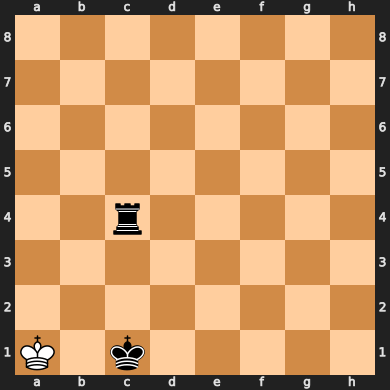

In [ ]:
chess.Board("8/8/8/8/2r5/8/8/K1k5 b - -")

(d) Danach werden alle Stellungen aus S berechnet, in denen der Spieler, der am Zug ist, mit jedem seiner Züge in einer Stellung aus der Menge S_1 landet, also matt gesetzt werden kann. Diese Stellungen werden zu einer Menge S_2 zusammen gefasst und aus S entfernt. S_2 enthält also die Stellungen, in denen der Spieler der am Zug ist, im nächsten Zug matt gesetzt werden kann, unabhängig davon, wie er selber zieht.

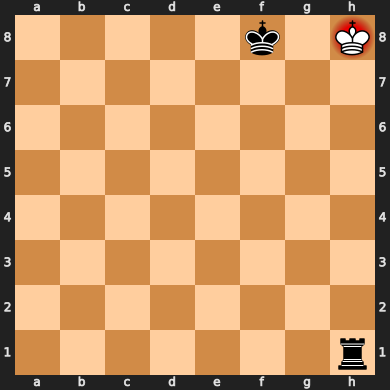

In [ ]:
chess.Board(s0.pop())

In [ ]:
len(s0)

210

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f6e34dfb-c85e-40db-bde6-d0ca8b0148c0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>